### Import required packages and limit GPU usage

In [81]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import csv
import sys
#sys.path.append('/content/KD')
# Import the module
import networks
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
use_gpu = True    # set use_gpu to True if system has gpu
gpu_id = 0        # id of gpu to be used
cpu_device = torch.device('cpu')
# fast_device is where computation (training, inference) happens
fast_device = torch.device('cpu')
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2'    # set visible devices depending on system configuration
    fast_device = torch.device('cuda:' + str(gpu_id))

In [17]:
def reproducibilitySeed():
    """
    Ensure reproducibility of results; Seeds to 0
    """
    torch_init_seed = 0
    torch.manual_seed(torch_init_seed)
    numpy_init_seed = 0
    np.random.seed(numpy_init_seed)
    if use_gpu:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

reproducibilitySeed()

In [46]:
checkpoints_path_teacher = 'checkpoints_teacher/'
checkpoints_path_student = 'checkpoints_student/'
if not os.path.exists(checkpoints_path_teacher):
    os.makedirs(checkpoints_path_teacher)
if not os.path.exists(checkpoints_path_student):
    os.makedirs(checkpoints_path_student)

### Load dataset

In [18]:
import torchvision
import torchvision.transforms as transforms

# Set up transformations for CIFAR-10
transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),  # Augment training data by padding 4 and random cropping
        transforms.RandomHorizontalFlip(),     # Randomly flip images horizontally
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalization for CIFAR-10
    ]
)

# Load CIFAR-10 dataset
train_val_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./CIFAR10_dataset/', train=False,
                                            download=True, transform=transform_test)

# Split the training dataset into training and validation
num_train = int(0.95 * len(train_val_dataset))  # 95% of the dataset for training
num_val = len(train_val_dataset) - num_train  # Remaining 5% for validation
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [num_train, num_val])

# DataLoader setup
batch_size = 128
train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Train teacher network

In [6]:
num_epochs = 100
print_every = 100    # Interval size for which to print statistics of training

In [7]:
# Define hyperparameter ranges
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-3]
momentums = [0.90]
dropout_probabilities = [(0.0, 0.0)]

# Prepare the list of hyperparameters
hparams_list = []
for hparam_tuple in itertools.product(dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {
        'dropout_input': hparam_tuple[0][0],
        'dropout_hidden': hparam_tuple[0][1],
        'weight_decay': hparam_tuple[1],
        'lr_decay': hparam_tuple[2],
        'momentum': hparam_tuple[3],
        'lr': hparam_tuple[4]
    }
    hparams_list.append(hparam)

# Results dictionary
results = {}

# CSV file setup
csv_file = "checkpoints_teacher/results_teacher.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Test Accuracy", "Training Time (s)"])

# Training and logging
for hparam in hparams_list:
    print('Training with hparams' + utils.hparamToString(hparam))

    # Measure training time
    start_time = time.time()

    reproducibilitySeed()
    teacher_net = networks.TeacherNetwork()
    teacher_net = teacher_net.to(fast_device)

    hparam_tuple = utils.hparamDictToTuple(hparam)
    results[hparam_tuple] = utils.trainTeacherOnHparam(teacher_net, hparam, num_epochs, train_val_loader, None, print_every=print_every, fast_device=fast_device)

    training_time = time.time() - start_time

    # Save model
    save_path = checkpoints_path_teacher + utils.hparamToString(hparam) + '_final.tar'
    torch.save({
        'results': results[hparam_tuple],
        'model_state_dict': teacher_net.state_dict(),
        'epoch': num_epochs
    }, save_path)

    # Calculate test accuracy
    _, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
    print('Test accuracy: ', test_accuracy)

    # Write results to CSV
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
            hparam['lr_decay'], hparam['momentum'], hparam['lr'],
            test_accuracy, training_time
        ])

print(f"Results saved to {csv_file}")

Training with hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Fail

[1,   100/  391] train loss: 1.125 train accuracy: 0.648
[1,   200/  391] train loss: 0.846 train accuracy: 0.664
[1,   300/  391] train loss: 0.937 train accuracy: 0.680
[2,   100/  391] train loss: 0.684 train accuracy: 0.734
[2,   200/  391] train loss: 0.758 train accuracy: 0.758
[2,   300/  391] train loss: 0.851 train accuracy: 0.742
[3,   100/  391] train loss: 0.781 train accuracy: 0.703
[3,   200/  391] train loss: 0.497 train accuracy: 0.844
[3,   300/  391] train loss: 0.683 train accuracy: 0.766
[4,   100/  391] train loss: 0.533 train accuracy: 0.820
[4,   200/  391] train loss: 0.643 train accuracy: 0.773
[4,   300/  391] train loss: 0.632 train accuracy: 0.781
[5,   100/  391] train loss: 0.443 train accuracy: 0.844
[5,   200/  391] train loss: 0.467 train accuracy: 0.836
[5,   300/  391] train loss: 0.693 train accuracy: 0.758
[6,   100/  391] train loss: 0.648 train accuracy: 0.773
[6,   200/  391] train loss: 0.510 train accuracy: 0.820
[6,   300/  391] train loss: 0.

### load pre-trained teacher network

In [20]:
# Path to the saved model
teacher_path = "checkpoints_teacher/dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001_final2.tar"

# Initialize the network
teacher_net = networks.TeacherNetwork()
teacher_net = teacher_net.to(fast_device)

# Load the checkpoint
checkpoint = torch.load(teacher_path)

# Load the state dictionary into the model
teacher_net.load_state_dict(checkpoint['model_state_dict'])

# pre-trained teacher accuracy
reproducibilitySeed()
_, test_accuracy = utils.getLossAccuracyOnDataset(teacher_net, test_loader, fast_device)
print('test accuracy: ', test_accuracy)

c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\17598\AppData\Local\Temp\ipykernel_15996\2752411799.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickl

test accuracy:  0.8654


### Student Network

#### Student Network (with training)

In [86]:
num_epochs = 30
print_every = 100

In [21]:
def count_parameters(model):
    """
    Counts the total number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose parameters need to be counted.

    Returns:
        int: Total number of trainable parameters.
    """
    return sum((p.data != 0).sum().item() for p in model.parameters() if p.requires_grad)


def count_zero_parameters(model):
    """
    Counts the number of trainable parameters that are exactly zero in a PyTorch model.

    Args:
        model (torch.nn.Module): The model whose zero parameters need to be counted.

    Returns:
        int: Total number of trainable parameters that are exactly zero.
    """
    return sum((p.data == 0).sum().item() for p in model.parameters() if p.requires_grad)


In [17]:
count_parameters(teacher_net)

11181642

In [87]:
# CSV file setup
csv_file = "checkpoints_student/results_student.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Alpha", "Temperature", "Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

In [96]:
csv_file = "checkpoints_student/results_student.csv"

# Hypothetical setup, please adjust according to actual import paths and methods
temperatures = [10]
alphas = [0.5]
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-3]
momentums = [0.9]
dropout_probabilities = [(0.0, 0.0)]
hparams_list = []

for hparam_tuple in itertools.product(alphas, temperatures, dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {}
    hparam['alpha'] = hparam_tuple[0]
    hparam['T'] = hparam_tuple[1]
    hparam['dropout_input'] = hparam_tuple[2][0]
    hparam['dropout_hidden'] = hparam_tuple[2][1]
    hparam['weight_decay'] = hparam_tuple[3]
    hparam['lr_decay'] = hparam_tuple[4]
    hparam['momentum'] = hparam_tuple[5]
    hparam['lr'] = hparam_tuple[6]
    hparams_list.append(hparam)

results_distill = {}
pruning_factors = [i/20 for i in range(1, 20, 2)]

# Training and logging
for pruning_factor in pruning_factors:
    for hparam in hparams_list:
        print('Training with hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

        # Measure training time
        start_time = time.time()

        reproducibilitySeed()
        student_net = networks.StudentNetwork(pruning_factor, teacher_net)
        student_net = student_net.to(fast_device)
        hparam_tuple = utils.hparamDictToTuple(hparam)

        student_params_num = count_parameters(student_net)
        print(pruning_factor, student_params_num, count_parameters(teacher_net))

        # Train the student network
        results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs,
                                                                                    train_val_loader, None,
                                                                                    print_every=print_every,
                                                                                    fast_device=fast_device)

        training_time = time.time() - start_time

        # Count parameters
        student_params_num = count_parameters(student_net)
        print(pruning_factor, student_params_num, count_parameters(teacher_net))

        # Save model
        save_path = checkpoints_path_student + utils.hparamToString(hparam) + f'_pruning_{pruning_factor}_final.tar'
        torch.save({
            'results': results_distill[(hparam_tuple, pruning_factor)],
            'model_state_dict': student_net.state_dict(),
            'epoch': num_epochs
        }, save_path)

        # Calculate test accuracy
        _, test_accuracy = utils.getLossAccuracyOnDataset(student_net, test_loader, fast_device)
        print('Test accuracy: ', test_accuracy)

        # Write results to CSV
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                hparam['alpha'], hparam['T'], hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
                hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
                test_accuracy, training_time
            ])

print(f"Results saved to {csv_file}")

Training with hparamsT=10, alpha=0.5, dropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.05


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


0.05 10623041 11181642


c:\Users\17598\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[1, 100/391] train loss: 1.655 train accuracy: 0.727
[1, 200/391] train loss: 0.861 train accuracy: 0.836
[1, 300/391] train loss: 1.269 train accuracy: 0.766
[2, 100/391] train loss: 1.052 train accuracy: 0.797
[2, 200/391] train loss: 0.932 train accuracy: 0.867
[2, 300/391] train loss: 0.982 train accuracy: 0.820
[3, 100/391] train loss: 0.851 train accuracy: 0.867
[3, 200/391] train loss: 0.863 train accuracy: 0.898
[3, 300/391] train loss: 0.826 train accuracy: 0.883
[4, 100/391] train loss: 0.562 train accuracy: 0.898
[4, 200/391] train loss: 0.837 train accuracy: 0.828
[4, 300/391] train loss: 0.616 train accuracy: 0.922
[5, 100/391] train loss: 0.586 train accuracy: 0.914
[5, 200/391] train loss: 0.499 train accuracy: 0.883
[5, 300/391] train loss: 0.799 train accuracy: 0.836
[6, 100/391] train loss: 0.520 train accuracy: 0.914
[6, 200/391] train loss: 0.641 train accuracy: 0.883
[6, 300/391] train loss: 0.701 train accuracy: 0.883
[7, 100/391] train loss: 0.561 train accuracy:

#### Student Network (without training)

In [89]:
# CSV file setup
csv_file = "checkpoints_student/results_student_wo.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Dropout Input", "Dropout Hidden", "Weight Decay", "LR Decay", "Momentum", "Learning Rate", "Pruning Factor", "Zero Parameters", "Test Accuracy", "Training Time (s)"])

In [91]:
# Define hyperparameter ranges
learning_rates = [1e-2]
learning_rate_decays = [0.95]
weight_decays = [1e-3]
momentums = [0.90]
dropout_probabilities = [(0.0, 0.0)]

# Prepare the list of hyperparameters
hparams_list = []
for hparam_tuple in itertools.product(dropout_probabilities, weight_decays, learning_rate_decays, momentums, learning_rates):
    hparam = {
        'dropout_input': hparam_tuple[0][0],
        'dropout_hidden': hparam_tuple[0][1],
        'weight_decay': hparam_tuple[1],
        'lr_decay': hparam_tuple[2],
        'momentum': hparam_tuple[3],
        'lr': hparam_tuple[4]
    }
    hparams_list.append(hparam)

# Results dictionary
results = {}
pruning_factors = [i/20 for i in range(1, 20)]

# Training and logging
for pruning_factor in pruning_factors:
    for hparam in hparams_list:
        print('Training without hparams' + utils.hparamToString(hparam) + f' and pruning factor {pruning_factor}')

        # Measure training time
        start_time = time.time()

        reproducibilitySeed()
        student_net_wo = networks.StudentNetwork(pruning_factor, teacher_net)
        student_net_wo = student_net_wo.to(fast_device)
        #hparam_tuple = utils.hparamDictToTuple(hparam)

        # Count parameters
        student_params_num = count_parameters(student_net_wo)
        print(pruning_factor, student_params_num, count_parameters(teacher_net))

        # Train the student network
        #results_distill[(hparam_tuple, pruning_factor)] = utils.trainStudentOnHparam(teacher_net, student_net, hparam, num_epochs,
                                                                                    #train_val_loader, None,
                                                                                    #print_every=print_every,
                                                                                    #fast_device=fast_device)

        training_time = time.time() - start_time

        # Save model
        #save_path = checkpoints_path_student + utils.hparamToString(hparam) + f'_pruning_{pruning_factor}_w/o_final.tar'
        #torch.save({
            #'results': results_distill[(hparam_tuple, pruning_factor)],
            #'model_state_dict': student_net.state_dict(),
            #'epoch': num_epochs
        #}, save_path)

        # Calculate test accuracy
        _, test_accuracy = utils.getLossAccuracyOnDataset(student_net_wo, test_loader, fast_device)
        print('Test accuracy: ', test_accuracy)

        # Write results to CSV
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                hparam['dropout_input'], hparam['dropout_hidden'], hparam['weight_decay'],
                hparam['lr_decay'], hparam['momentum'], hparam['lr'], pruning_factor, student_params_num,
                test_accuracy, training_time
            ])

print(f"Results saved to {csv_file}")

Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.05
0.05 10623041 11181642
Test accuracy:  0.8655
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.1
0.1 10064438 11181642
Test accuracy:  0.8648
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.15
0.15 9505835 11181642
Test accuracy:  0.8653
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.2
0.2 8947233 11181642
Test accuracy:  0.8652
Training without hparamsdropout_hidden=0.0, dropout_input=0.0, lr=0.01, lr_decay=0.95, momentum=0.9, weight_decay=0.001 and pruning factor 0.25
0.25 8388632 11181642
Test accuracy:  0.8648
Training without hparamsdropout_hidden=0.0, dropout_input

### Result

In [110]:
import pandas as pd
result = pd.read_csv("checkpoints_student/results_student.csv")
result = result[['Pruning Factor', 'Test Accuracy', 'Training Time (s)']]
result_wo = pd.read_csv("checkpoints_student/results_student_wo.csv")
result_wo = result_wo[['Pruning Factor', 'Test Accuracy', 'Training Time (s)']]

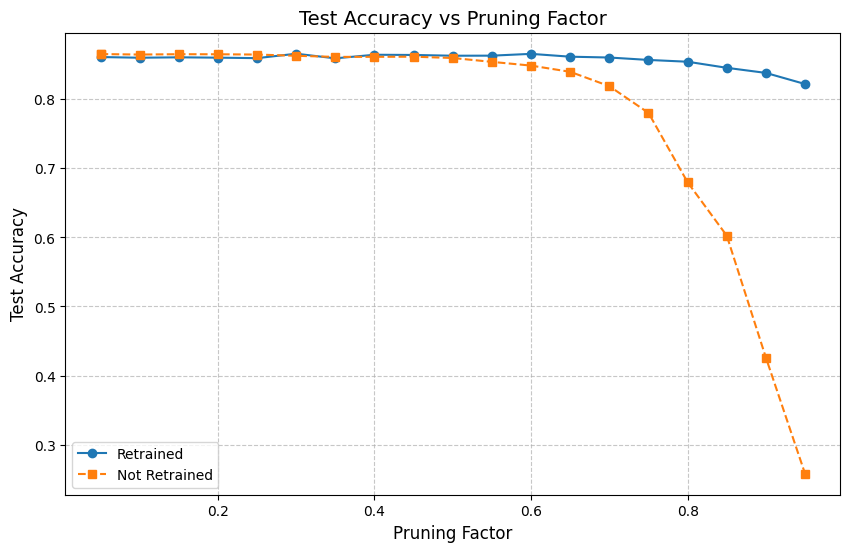

In [101]:
import matplotlib.pyplot as plt
import os

# Ensure the 'images' folder exists
os.makedirs('images', exist_ok=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(result['Pruning Factor'], result['Test Accuracy'], marker='o', linestyle='-', label='Retrained')
plt.plot(result_wo['Pruning Factor'], result_wo['Test Accuracy'], marker='s', linestyle='--', label='Not Retrained')

# Adding labels, title, and legend
plt.title('Test Accuracy vs Pruning Factor', fontsize=14)
plt.xlabel('Pruning Factor', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Save the plot to the 'images' folder
output_path = os.path.join('images', 'test_accuracy_vs_pruning_factor.png')
plt.savefig(output_path)

# Display the plot
plt.show()

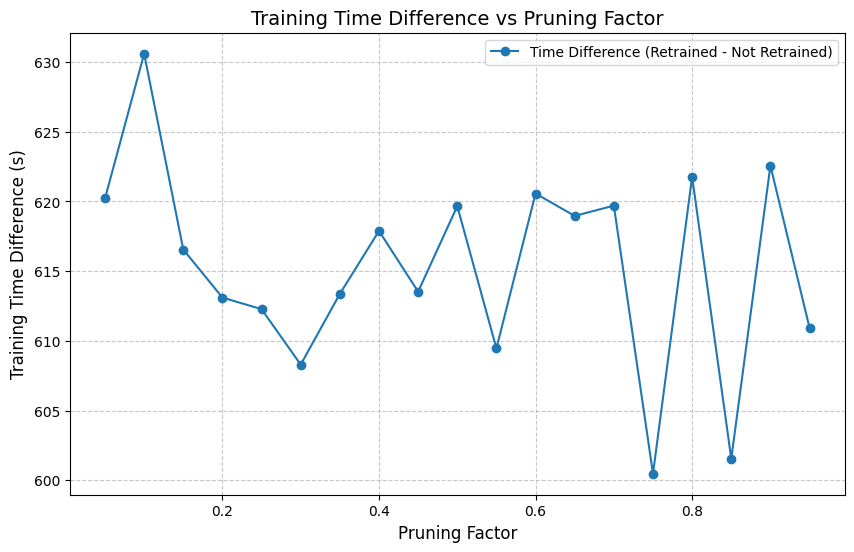

In [111]:
# Ensure the 'images' folder exists
os.makedirs('images', exist_ok=True)

# Compute the difference in training time
training_time_diff = result['Training Time (s)'] - result_wo['Training Time (s)']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(result['Pruning Factor'], training_time_diff, marker='o', linestyle='-', label='Time Difference (Retrained - Not Retrained)')

# Adding labels, title, and legend
plt.title('Training Time Difference vs Pruning Factor', fontsize=14)
plt.xlabel('Pruning Factor', fontsize=12)
plt.ylabel('Training Time Difference (s)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Save the plot to the 'images' folder
output_path = os.path.join('images', 'training_time_difference_vs_pruning_factor.png')
plt.savefig(output_path)

# Display the plot
plt.show()
